In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from glob import glob
from datetime import datetime
from tqdm import tqdm
from xhistogram.xarray import histogram
from pyproj import Transformer
import gsw
import warnings
from functions import gaussian_filter

In [2]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 20, dashboard_address=':4242') #number of cores
client = Client(cluster) # go check dask dashboard

In [3]:
if not os.path.exists(f"../../data/processed/dopplerscatt_moses"):
    os.mkdir(f"../../data/processed/dopplerscatt_moses")

In [4]:
wgs2utm = Transformer.from_crs("EPSG:4326", "EPSG:32610").transform # x, y = f(lat, lon)

dt0 = datetime(2022,10,24)

In [9]:
fname = glob(f"../../data/external/dopplerscatt_moses/dopplerscatt/*{dt0.strftime('%Y%m%d')}*")[0]
dscatt = xr.open_dataset(fname)
dscatt = dscatt.where(dscatt.azimuth_diversity_flag_all_lines==0)

dscatt["u_current_all_lines"] = gaussian_filter(dscatt["u_current_all_lines"], sigma = 5)
dscatt["v_current_all_lines"] = gaussian_filter(dscatt["v_current_all_lines"], sigma = 5)

f = gsw.f(dscatt.latitude.mean())
dscatt["Ro"] = (
    dscatt["v_current_all_lines"].differentiate("x") - 
    dscatt["u_current_all_lines"].differentiate("y")
).rename("Ro") / f

dscatt["wind_u"] = dscatt.wind_speed_all_lines * np.sin(np.deg2rad(dscatt.wind_dir_all_lines))
dscatt["wind_v"] = dscatt.wind_speed_all_lines * np.cos(np.deg2rad(dscatt.wind_dir_all_lines))
dscatt["current_speed"] = np.sqrt(dscatt["u_current_all_lines"]**2 + dscatt["v_current_all_lines"]**2)

for var in ["u_current_all_lines", "v_current_all_lines"]:
    dscatt[f"mean_{var}"] = gaussian_filter(dscatt[var], sigma = 21)

output_fname = f"../../data/processed/dopplerscatt_moses/dopplerscatt_{dt0.strftime('%Y%m%d')}.nc"

dscatt.to_netcdf(output_fname)

In [10]:
fnames = glob(f"../../data/external/dopplerscatt_moses/moses/*{dt0.strftime('%Y%m%d')}*")
fnames.sort()


H = []
for fname in tqdm(fnames):

    ds = xr.open_dataset(fname)
    ds["SST"] = ds["SST"] + 9.8 # bias from Sentinel
    
    x, y = wgs2utm(ds.latitude, ds.longitude)
    ds = ds.assign(
        x = (xr.ones_like(ds.longitude)*x),
        y = (xr.ones_like(ds.latitude)*y),
    )

    xm = (ds.x.where(~np.isnan(ds.SST))).mean("across")
    ym = (ds.y.where(~np.isnan(ds.SST))).mean("across")

    median = ds.SST.median("across")
    
    ds = ds.chunk(along = 1000, across = 100)
    
    dist = np.sqrt((ds.x-xm)**2 + (ds.y-ym)**2).rename("dist")*1e-3
    
    bins = [np.arange(-0.5, 0.3, 0.01), np.arange(0, 2.5, 0.05)]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        Hi = histogram(
            (ds.SST-median),
            dist, bins = bins).load()
        
    H.append(Hi)

H = xr.concat(H, "passing").sum("passing")
Hc = (H.cumsum("SST_bin")/H.sum("SST_bin"))

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [01:31<00:00,  7.59s/it]


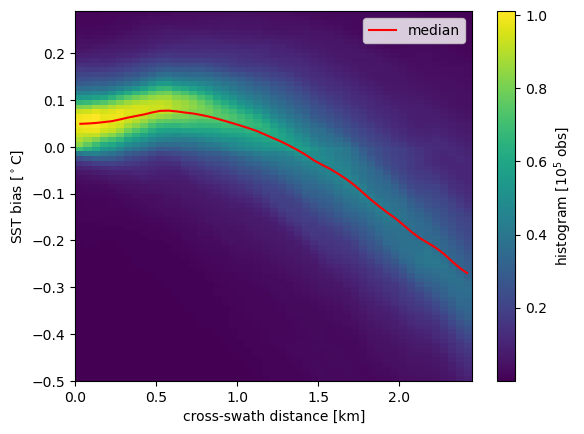

In [11]:
fig, ax = plt.subplots()
(H*1e-5).plot(ax = ax, cbar_kwargs = dict(label = "histogram [10$^5$ obs]"))
C = Hc.plot.contour(ax = ax, levels = [0.5], colors = ["r"])
ax.plot([], [], "r", label = "median")
ax.legend()
ax.set(xlabel = "cross-swath distance [km]", ylabel = "SST bias [$^\circ$C]")
fig.savefig("../../img/moses_sst_bias.png", dpi = 300, bbox_inches = "tight")

dist, ta = C.allsegs[0][0].T
bias = xr.DataArray(ta, dims = ["dist"], coords = dict(dist = ("dist", dist)))


In [14]:
dx = 30 # meters
bins = [
    np.arange(dscatt.x.min(), dscatt.x.max(), dx),
    np.arange(dscatt.y.min(), dscatt.y.max(), dx)
]

threshold = 0.2 #seconds per measurements

H = []
T = []

for fname in tqdm(fnames):

    ds = xr.open_dataset(fname)
    ds["SST"] = ds.SST + 9.8 # Sentinel bias

    time = (ds.time.astype("float64").where(~np.isnan(ds.time)).mean("across")*1e-9)
    time = time-time.min()
    time = time.rolling(along = 11, min_periods = 1).mean()
    
    x, y = wgs2utm(ds.latitude, ds.longitude)
    ds = ds.assign(
        x = (xr.ones_like(ds.longitude)*x),
        y = (xr.ones_like(ds.latitude)*y),
    )

    ds["SST"] = ds.SST.where(np.abs(time.differentiate("along"))<threshold)
    
    xm = (ds.x.where(~np.isnan(ds.SST))).mean("across")
    ym = (ds.y.where(~np.isnan(ds.SST))).mean("across")
    
    dist = np.sqrt((ds.x-xm)**2 + (ds.y-ym)**2).rename("dist")*1e-3

    bias_i = bias.interp(dist = dist, method="linear", kwargs={"fill_value": "extrapolate"})

    ds["SST"] = ds["SST"] - bias_i

    # ds["SST"] = ds.SST.where(dist<2.4)
    
    ds = ds.chunk(along = 1000, across = 200)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        Hi = histogram(ds.x, ds.y, bins = bins, weights = ~np.isnan(ds.SST)).load()
        Ti = histogram(ds.x, ds.y, bins = bins, weights = ds.SST.fillna(0)).load() / Hi
    
    H.append(Hi)
    T.append(Ti)
    
H = xr.concat(H, "lines")
T = xr.concat(T, "lines")

moses = ((T*H).sum("lines")/H.sum("lines")).rename("SST")

sigma = 10
mosesm = gaussian_filter(moses, sigma = sigma).rename("mean_SST")
mosesm.attrs["sigma"] = f"{sigma*dx} meters"

output_fname = f"../../data/processed/dopplerscatt_moses/moses_{dt0.strftime('%Y%m%d')}_binned.nc"

xr.merge([moses,mosesm]).to_netcdf(output_fname)

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [03:18<00:00, 16.56s/it]
